# Mesa Testing

In this notebook we test and develop the needed classes that are going to be used in the eventual P2P-energy trading simulation.

In [520]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math

import mesa
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [521]:
class Household_2(mesa.Agent):
    """
    Agent representing a household with energy consumption, production, and trading behavior.
    """

    def __init__(self, model):
        """
        Initializes a household agent with a random number of solar panels and corresponding production/consumption.
        """
        super().__init__(model)

        values = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
        probabilities = np.array([0.9, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.07, 0.01, 0.07, 0.01, 0.01, 0.01, 0.12])
        probabilities /= probabilities.sum()
        self.amount_of_solarpanels = np.random.choice(values, p=probabilities)

        self.supply = 1
        self.demand = 1

        self.remaining_energy = 0
        self.consumed = 0
        self.produced = 0
        self.trade_amount = 0

        self.energy_price = self.model.energy_price
        self.grid_price = 0.1710

        # print(f"[INIT] Household initialized with {self.amount_of_solarpanels} solar panels.")
        # print(f"[INIT] Consumption: {self.consumption_data} | Production: {self.production_data}")

    def trade_energy(self):
        # print(f"\n[TRADE] Time: Day {self.model.day_str}, Hour {self.model.hour}")
        self._calculate_energy()
        self._trading()

        if self.remaining_energy > 0:
            self.model.hourly_supply[self.model.hour] += self.remaining_energy
        else:
            self.model.hourly_demand[self.model.hour] += abs(self.remaining_energy)

    def _calculate_energy(self):
        self.consumed = self._lookup_data_for_agent(self.model.consumption_data)
        self.solar_strength = self._lookup_data_for_agent(self.model.production_data)

        self.produced = self.solar_strength * (self.amount_of_solarpanels * 1.7) # Average solar panel is 1.7m2

        self.remaining_energy = self.produced - self.consumed
        # print(f"[CALC] Consumed: {self.consumed}, Produced: {self.produced}, Remaining: {self.remaining_energy}")

    def _lookup_data_for_agent(self, data):
        household_id = f"household_{self.unique_id}"
        day_data = data.loc[self.model.day_str]
        lookup_data = day_data[day_data["household_id"] == household_id][f"{self.model.hour}:00"].values[0]
        return lookup_data

    def _trading(self):
        self._look_for_trades()
        if not self.buyers:
            # print("[TRADE] No buyers found.")
            return

        if self.remaining_energy <= 0:
            # print("[TRADE] No surplus energy to trade.")
            return

        self._exchange_energy(self.buyers)

    def _look_for_trades(self):
        self.buyers = [
            agent for agent in self.model.agents
            if agent.remaining_energy < agent.consumed
        ]
        self.sellers = [
            agent for agent in self.model.agents
            if agent.remaining_energy > agent.consumed
        ]
        # print(f"[MARKET] Buyers: {len(self.buyers)} | Sellers: {len(self.sellers)}")

    def _exchange_energy(self, buyers):
        for buyer in buyers:
            potential_trade = buyer.consumed - buyer.remaining_energy
            if potential_trade <= 0:
                continue

            trade_amount = min(self.remaining_energy, potential_trade)

            if trade_amount <= 0:
                continue

            self.remaining_energy -= trade_amount
            buyer.remaining_energy += trade_amount

            # print(f"[EXCHANGE] Traded {trade_amount} units to Buyer (ID: {buyer.unique_id})")
            # print(f"[TRADER] Remaining energy: {self.remaining_energy}W")

            if self.remaining_energy <= 0:
                # print("[TRADE] No more energy to trade.")
                break

    def _change_price(self):
        self.demand = len(self.buyers)
        if len(self.sellers) != 0:
            self.supply = len(self.sellers)
        else:
            return None
        new_price = self.energy_price * (self.demand / self.supply)
        new_price = max(0.10, min(new_price, self.grid_price))
        # print(f"[PRICE] Old Price: {self.energy_price:.4f}, New Price: {new_price:.4f}")
        self.energy_price = new_price

In [522]:
import pandas as pd
import numpy as np

# Constants
num_households = 30
days = pd.date_range(start='2024-01-01', end='2024-02-28', freq='D')
formatted_days = days.strftime('%d-%m-%Y')
hours = [f"{h}:00" for h in range(24)]

# Profiles for tracking behavior (not used in consumption generation for now)
profiles = ['early_bird', 'night_owl', 'midday_worker', 'morning_person']
profile_probs = [0.3, 0.3, 0.2, 0.2]

household_ids = [f"household_{i}" for i in range(num_households)]
household_profiles = np.random.choice(profiles, num_households, p=profile_probs)

# Base hourly consumption profile (normalized to ~12 kWh/day total)
def realistic_consumption_pattern():
    base = np.array([
        0.2, 0.15, 0.15, 0.15, 0.2,  # 0:00–4:00
        0.4, 0.6, 0.8, 0.6,  # 5:00–8:00 (morning)
        0.4, 0.3, 0.3, 0.4, 0.4, 0.3,  # 9:00–14:00
        0.4, 0.6, 1.0, 0.9, 0.8, 0.6,  # 15:00–20:00 (evening)
        0.4, 0.3, 0.2  # 21:00–23:00
    ])
    noise = np.random.normal(0, 0.05, size=24)
    profile = base + noise
    profile = np.clip(profile, 0.1, None)
    profile *= np.random.uniform(10, 15) / profile.sum()
    return np.round(profile, 2)

# Base solar production profile (per m²)
def realistic_production_pattern(solar_area):
    production = []
    for h in range(24):
        if 6 <= h <= 17:
            solar_multiplier = max(0, np.sin((np.pi / 12) * (h - 6)))  # curve from 0 to 1 back to 0
            cloud_factor = np.random.uniform(0.6, 1.0)
            prod = solar_area * solar_multiplier * cloud_factor * 0.2  # 0.2 is efficiency constant
        else:
            prod = 0
        production.append(round(prod, 2))
    return production

# Generate Data
consumption_records = []
production_records = []

for date_str in formatted_days:
    for household_id, profile in zip(household_ids, household_profiles):
        # Random solar panel area
        solar_area = np.random.randint(4, 15)  # typical home might have 8–12 m²

        consumption = realistic_consumption_pattern()
        production = realistic_production_pattern(solar_area)

        consumption_records.append([date_str, household_id, profile] + list(consumption))
        production_records.append([date_str, household_id, profile] + production)

# Create DataFrames
columns = ['date', 'household_id', 'profile'] + hours

consumption_df = pd.DataFrame(consumption_records, columns=columns).set_index('date')
production_df = pd.DataFrame(production_records, columns=columns).set_index('date')

# Preview a sample
print("Consumption Sample:")
display(consumption_df.head(2))
print("\nProduction Sample:")
display(production_df.head(2))


Consumption Sample:


,household_id,profile,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
date,,,,,,,,,,,,,,,,,,,,,
01-01-2024,household_0,early_bird,0.27,0.12,0.21,0.22,0.17,0.42,0.61,0.69,...,0.34,0.44,0.57,0.98,0.99,0.74,0.61,0.44,0.21,0.18
01-01-2024,household_1,midday_worker,0.26,0.27,0.23,0.19,0.25,0.44,0.65,1.02,...,0.36,0.46,0.66,1.24,1.00,0.95,0.72,0.53,0.40,0.26



Production Sample:


,household_id,profile,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
date,,,,,,,,,,,,,,,,,,,,,
01-01-2024,household_0,early_bird,0,0,0,0,0,0,0.0,0.38,...,1.42,0.95,0.75,0.42,0,0,0,0,0,0
01-01-2024,household_1,midday_worker,0,0,0,0,0,0,0.0,0.30,...,1.04,0.79,0.45,0.25,0,0,0,0,0,0


In [523]:
# Define the 8-day range
dates = pd.date_range(start="2024-01-01", end="2024-02-28", freq="D").strftime("%d-%m-%Y")
hours = [f"{h}:00" for h in range(24)]
num_households = 30

# Define profiles
profiles = ["early_bird", "night_owl", "average"]
households = [f"household_{i}" for i in range(num_households)]
household_profiles = np.random.choice(profiles, size=num_households)

# Create solar strength based on weather condition (cloudy, partly cloudy, sunny)
weather_types = ["cloudy", "partly_cloudy", "sunny"]
weather_distribution = [0.3, 0.4, 0.3]  # 30% cloudy, 40% partly, 30% sunny

weather_per_day = np.random.choice(weather_types, size=len(dates), p=weather_distribution)
solar_profile = {
    "cloudy": lambda h: np.clip(np.random.normal(0.1, 0.05), 0, 0.2),
    "partly_cloudy": lambda h: np.clip(np.sin((h - 6) / 12 * np.pi) * 0.5 + np.random.normal(0, 0.05), 0, 0.6),
    "sunny": lambda h: np.clip(np.sin((h - 6) / 12 * np.pi) * 0.9 + np.random.normal(0, 0.05), 0, 1.0),
}

# Build the production dataframe
production_data = []

for date, weather in zip(dates, weather_per_day):
    for h_id, profile in zip(households, household_profiles):
        row = {
            "household_id": h_id,
            "profile": profile
        }
        for hour in range(24):
            row[f"{hour}:00"] = round(solar_profile[weather](hour), 3)
        row["date"] = date
        production_data.append(row)

production_df = pd.DataFrame(production_data)
production_df.set_index("date", inplace=True)

production_df.head()

,household_id,profile,0:00,1:00,2:00,3:00,4:00,5:00,6:00,7:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
date,,,,,,,,,,,,,,,,,,,,,
01-01-2024,household_0,early_bird,0.0,0.0,0.0,0.0,0.0,0.0,0.029,0.179,...,0.741,0.663,0.446,0.314,0.000,0.0,0.0,0.0,0.0,0.0
01-01-2024,household_1,night_owl,0.0,0.0,0.0,0.0,0.0,0.0,0.064,0.221,...,0.717,0.546,0.425,0.235,0.000,0.0,0.0,0.0,0.0,0.0
01-01-2024,household_2,early_bird,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.226,...,0.736,0.646,0.498,0.152,0.002,0.0,0.0,0.0,0.0,0.0
01-01-2024,household_3,average,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.124,...,0.809,0.577,0.442,0.304,0.037,0.0,0.0,0.0,0.0,0.0
01-01-2024,household_4,average,0.0,0.0,0.0,0.0,0.0,0.0,0.043,0.277,...,0.787,0.627,0.442,0.164,0.000,0.0,0.0,0.0,0.0,0.0


In [524]:
class NewGrid(mesa.Model):
    def __init__(self, n, consumption_data, production_data, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n

        self.consumption_data = consumption_data
        self.production_data = production_data

        self.datetime = datetime(2024, 1, 1)
        self.hour = 0
        self.day_str = self.datetime.strftime("%d-%m-%Y")

        self.hourly_demand = [0] * 24
        self.hourly_supply = [0] * 24
        self.energy_price = 0.16
        self.grid_price = 0.171

        self.smoothing = 0.3
        self.elasticity = 0.4
        self.min_price = 0.10

        self.avg_demand = 1
        self.avg_supply = 1

        self.daily_energy_prices = []  # Store energy price per day
        self.hourly_surplus_deficit = []  # Store surplus/deficit per hour for households
        self.total_consumption_per_hour = []  # Total energy consumption per hour
        self.total_production_per_hour = []  # Total energy production per hour
        self.household_solar_panels = []  # Store number of solar panels per household
        self.pressure_price_data = []  # Store pressure vs price data for plotting
        self.trade_price_data = []  # Store price vs surplus/deficit for trading
        self.total_demand_history = []  # List to hold cumulative demand data
        self.total_supply_history = []  # List to hold cumulative supply data

        Household_2.create_agents(model=self, n=n)

    def _time_skip(self):
        if self.hour != 23:
            self.hour += 1
        else:
            self.datetime += relativedelta(days=1)
            self.day_str = self.datetime.strftime("%d-%m-%Y")
            self.hour = 0
        
        if self.hour == 0:
            self._update_energy_price()
            self.collect_daily_data()

        # Collect data for the day
        self.collect_hourly_data()

    def _update_energy_price(self):
        target_price = self._calculate_target_price()

        # --- Smoothed Transition ---
        self.energy_price = (1 - self.smoothing) * self.energy_price + self.smoothing * target_price

        # Output energy price for the day
        print(f"[DAILY PRICE UPDATE :: {self.day_str}]: "
            f"Price={self.energy_price:.4f}")

    def _calculate_target_price(self):
        elasticity = 0.5  # Default elasticity factor
        min_price = 0.10
        max_price = self.grid_price
        
        demand_list = self.hourly_demand
        supply_list = self.hourly_supply

        # Avoid zero division
        valid_hours = [i for i in range(24) if supply_list[i] > 0]
        if not valid_hours:
            return self.grid_price  # fallback

        hourly_pressures = [
        demand_list[i] / supply_list[i] for i in valid_hours
        ]
        
        # Calculate the average pressure across valid hours
        pressure = np.mean(hourly_pressures)

        # If demand exceeds supply, increase the price, but with diminishing returns
        if pressure > 1:
            # The more extreme the imbalance, the stronger the price increase
            price_increase = (pressure - 1) * elasticity
            new_price = self.energy_price * (1 + price_increase)
        else:
            # If supply exceeds demand, decrease the price but not too sharply
            price_decrease = (1 - pressure) * elasticity
            new_price = self.energy_price * (1 - price_decrease)

        # Apply bounds to ensure the price stays within the limits
        new_price = max(min_price, min(new_price, max_price))

        return new_price

    def collect_daily_data(self):
        # Collect the daily totals (once per day)
        self.total_demand_history.append(sum(self.hourly_demand))
        self.total_supply_history.append(sum(self.hourly_supply))

        self.daily_energy_prices.append(self.energy_price)

        # Reset hourly data for the next day
        self.hourly_demand = [0] * 24
        self.hourly_supply = [0] * 24

    def collect_hourly_data(self):
        # Collect hourly data that updates every hour
        self.total_consumption_per_hour.append(sum(agent.consumed for agent in self.agents))
        self.total_production_per_hour.append(sum(agent.produced for agent in self.agents))

        surplus_deficit = [agent.remaining_energy for agent in self.agents]
        self.hourly_surplus_deficit.append(surplus_deficit)

        # Collect household solar panel distribution
        solar_panels = [agent.amount_of_solarpanels for agent in self.agents]
        self.household_solar_panels.append(solar_panels)

        # Collect pressure vs price data
        pressures = [self.avg_demand / self.avg_supply]
        self.pressure_price_data.extend(zip(pressures, [self.energy_price] * len(pressures)))

        # Collect price vs surplus/deficit data for trading
        for agent in self.agents:
            self.trade_price_data.append((agent.remaining_energy, agent.energy_price))

    def step(self):
        self.agents.shuffle_do("trade_energy")
        for agent in self.agents:
            print(f"""
            Statistics for Agent {agent}:
            Current day: {self.day_str}
            Current energy price: {agent.energy_price}
            Current remaining energy: {agent.remaining_energy}
            Last consumed: {agent.consumed}
            Last produced: {agent.produced}
            Total agent amount: {self.num_agents}
            """)

    def long_step(self, n):
        for _ in range(0, n):
            self.agents.shuffle_do("trade_energy")

            self._time_skip()

In [525]:
sim = NewGrid(20, consumption_df, production_df)
sim.step()


            Statistics for Agent <__main__.Household_2 object at 0x000001ABCF18A630>:
            Current day: 01-01-2024
            Current energy price: 0.16
            Current remaining energy: -0.26
            Last consumed: 0.26
            Last produced: 0.0
            Total agent amount: 20
            

            Statistics for Agent <__main__.Household_2 object at 0x000001ABD0A8D4C0>:
            Current day: 01-01-2024
            Current energy price: 0.16
            Current remaining energy: -0.19
            Last consumed: 0.19
            Last produced: 0.0
            Total agent amount: 20
            

            Statistics for Agent <__main__.Household_2 object at 0x000001ABCAC06B40>:
            Current day: 01-01-2024
            Current energy price: 0.16
            Current remaining energy: -0.2
            Last consumed: 0.2
            Last produced: 0.0
            Total agent amount: 20
            

            Statistics for Agent <__main__.Househo

In [526]:
sim.long_step(7*24*8)

[DAILY PRICE UPDATE :: 02-01-2024]: Price=0.1486
[DAILY PRICE UPDATE :: 03-01-2024]: Price=0.1340
[DAILY PRICE UPDATE :: 04-01-2024]: Price=0.1238
[DAILY PRICE UPDATE :: 05-01-2024]: Price=0.1380
[DAILY PRICE UPDATE :: 06-01-2024]: Price=0.1479
[DAILY PRICE UPDATE :: 07-01-2024]: Price=0.1349
[DAILY PRICE UPDATE :: 08-01-2024]: Price=0.1457
[DAILY PRICE UPDATE :: 09-01-2024]: Price=0.1533
[DAILY PRICE UPDATE :: 10-01-2024]: Price=0.1431
[DAILY PRICE UPDATE :: 11-01-2024]: Price=0.1302
[DAILY PRICE UPDATE :: 12-01-2024]: Price=0.1424
[DAILY PRICE UPDATE :: 13-01-2024]: Price=0.1510
[DAILY PRICE UPDATE :: 14-01-2024]: Price=0.1425
[DAILY PRICE UPDATE :: 15-01-2024]: Price=0.1510
[DAILY PRICE UPDATE :: 16-01-2024]: Price=0.1570
[DAILY PRICE UPDATE :: 17-01-2024]: Price=0.1601
[DAILY PRICE UPDATE :: 18-01-2024]: Price=0.1506
[DAILY PRICE UPDATE :: 19-01-2024]: Price=0.1415
[DAILY PRICE UPDATE :: 20-01-2024]: Price=0.1504
[DAILY PRICE UPDATE :: 21-01-2024]: Price=0.1566
[DAILY PRICE UPDATE 

## Visualisation Ideas

- Energy demand vs supply over time
- Energy price fluctuations over time
- Individual household average energy production en consumption graph (voor tim en jasper)
- Trade Network graph
- Surplus/Defecit energy distribution across households
- Total energy production/consumption per time given (hour, day, week, month)
- Household solar panel distribution
- Trading Price dynamics (price vs surplus/deficit)
- Pressure vs Price
- Agent consumption and production over timespan (tim en jasper)

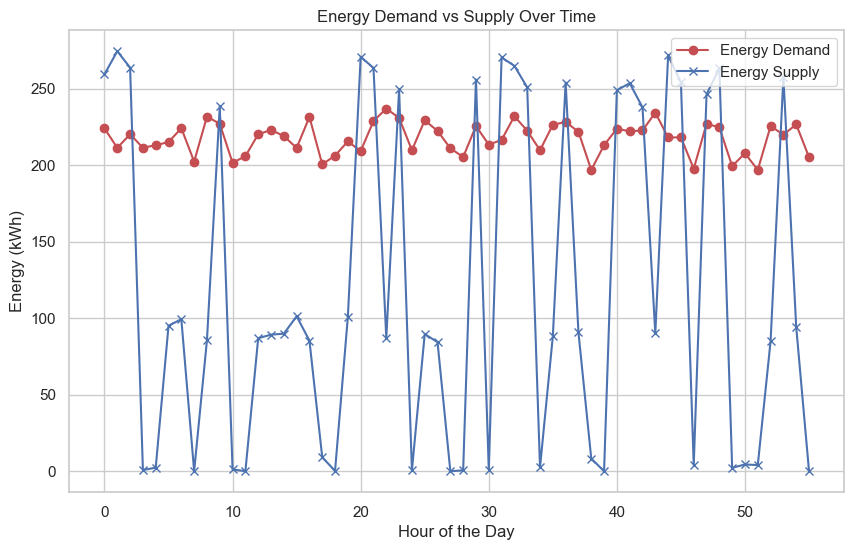

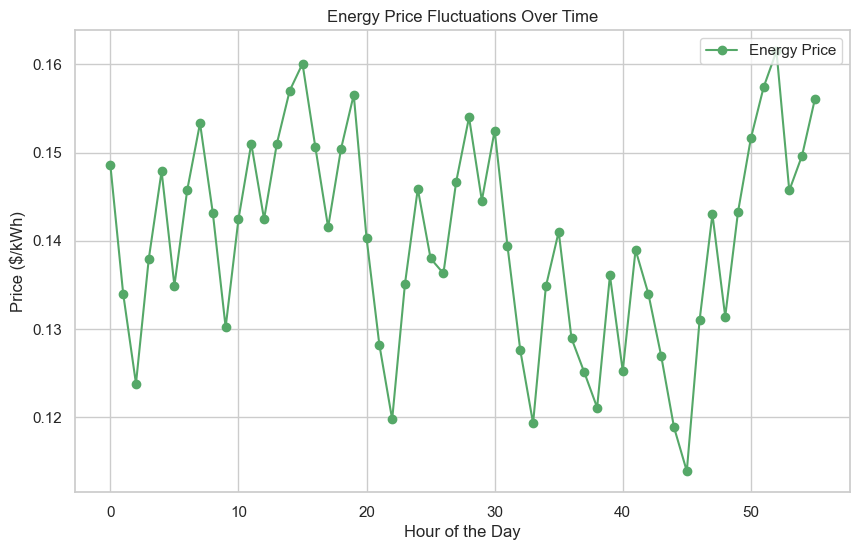

In [527]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Ensure the use of a nice style for the plots
sns.set_theme(style="whitegrid")

# ----- 1. Energy Demand vs Supply Over Time -----
def plot_energy_demand_vs_supply(model):
    # Aggregating data for demand and supply
    hours = range(len(model.total_demand_history))

    plt.figure(figsize=(10, 6))
    plt.plot(hours, model.total_demand_history, label='Energy Demand', color='r', marker='o')
    plt.plot(hours, model.total_supply_history, label='Energy Supply', color='b', marker='x')

    plt.title('Energy Demand vs Supply Over Time')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Energy (kWh)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# ----- 2. Energy Price Fluctuations Over Time -----
def plot_energy_price_fluctuations(model):
    # Plotting energy price over time
    hours = range(len(model.daily_energy_prices))

    plt.figure(figsize=(10, 6))
    plt.plot(hours, model.daily_energy_prices, label='Energy Price', color='g', marker='o')

    plt.title('Energy Price Fluctuations Over Time')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Price ($/kWh)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# ----- 4. Surplus/Deficit Energy Distribution Across Households -----
def plot_surplus_deficit_distribution(model):
    # Collect surplus/deficit data for households
    hours = range(len(model.hourly_surplus_deficit))
    surplus_deficit = [sum(hour_data) for hour_data in model.hourly_surplus_deficit]

    plt.figure(figsize=(10, 6))
    plt.plot(hours, surplus_deficit, label='Surplus/Deficit', color='orange', marker='x')

    plt.title('Surplus/Deficit Energy Distribution Across Households')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Energy (kWh)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# ----- 6. Household Solar Panel Distribution -----
def plot_solar_panel_distribution(model):
    # Collect solar panel distribution across households
    hours = range(len(model.household_solar_panels))
    solar_panels = [sum(hour_data) for hour_data in model.household_solar_panels]

    plt.figure(figsize=(10, 6))
    plt.plot(hours, solar_panels, label='Solar Panel Count', color='purple', marker='o')

    plt.title('Household Solar Panel Distribution')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Solar Panels')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# ----- 7. Trading Price Dynamics (Price vs Surplus/Deficit) -----
def plot_trading_price_dynamics(model):
    # Plot trading price vs surplus/deficit
    trading_data = model.trade_price_data
    surplus_deficit, prices = zip(*trading_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(surplus_deficit, prices, color='b', label='Price vs Surplus/Deficit', alpha=0.7)

    plt.title('Trading Price Dynamics (Price vs Surplus/Deficit)')
    plt.xlabel('Surplus/Deficit (kWh)')
    plt.ylabel('Price ($/kWh)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# ----- 8. Pressure vs Price -----
def plot_pressure_vs_price(model):
    # Plot pressure vs price dynamics
    pressures, prices = zip(*model.pressure_price_data)

    plt.figure(figsize=(10, 6))
    plt.plot(pressures, prices, label='Pressure vs Price', color='g', marker='o')

    plt.title('Pressure vs Price')
    plt.xlabel('Market Pressure (Demand/Supply)')
    plt.ylabel('Price ($/kWh)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# --- Usage of the functions ---
# Assuming you have an instance of the model `model`
plot_energy_demand_vs_supply(sim)
plot_energy_price_fluctuations(sim)